In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 01. Neural Network Regression with TensorFlow

There are many definitions for a [regression problem](https://en.wikipedia.org/wiki/Regression_analysis) but in our case, we're going to simplify it to be: predicting a number.

For example, you might want to:
- Predict the selling price of houses given information about them (such as number of rooms, size, number of bathrooms).
- Predict the coordinates of a bounding box of an item in an image.
- Predict the cost of medical insurance for an individual given their demographics (age, sex, gender, race).

In this notebook, we're going to set the foundations for how you can take a sample of inputs (this is your data), build a neural network to discover patterns in those inputs and then make a prediction (in the form of a number) based on those inputs.

## What we're going to cover

Specifically, we're going to go through doing the following with TensorFlow:
- Architecture of a regression model
- Input shapes and output shapes
  - `X`: features/data (inputs)
  - `y`: labels (outputs)
- Creating custom data to view and fit
- Steps in modelling
  - Creating a model
  - Compiling a model
    - Defining a loss function
    - Setting up an optimizer
    - Creating evaluation metrics
  - Fitting a model (getting it to find patterns in our data)
- Evaluating a model
  - Visualizng the model ("visualize, visualize, visualize")
  - Looking at training curves
  - Compare predictions to ground truth (using our evaluation metrics)
- Saving a model (so we can use it later)
- Loading a model



More specifically we're going to try predict the cost of medical insurance for individuals based on a number of different parameters such as, `age`, `sex`, `bmi`, `children`, `smoking_status` and `residential_region`.

To do, we'll leverage the pubically available [Medical Cost dataset](https://www.kaggle.com/mirichoi0218/insurance) available from Kaggle and [hosted on GitHub](https://github.com/stedy/Machine-Learning-with-R-datasets/blob/master/insurance.csv).

> 🔑 **Note:** When learning machine learning paradigms, you'll often go through a series of foundational techniques and then practice them by working with open-source datasets and examples. Just as we're doing now, learn foundations, put them to work with different problems. Every time you work on something new, it's a good idea to search for something like "problem X example with Python/TensorFlow" where you substitute X for your problem.

In [16]:
insurance =  pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv")
insurance

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [17]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [18]:
# Create column transformer (this will help us normalize/preprocess our data)
ct = make_column_transformer(
    (MinMaxScaler(), ["age", "bmi", "children"]),  # turn all values these columns between 0 and 1
    (OneHotEncoder(handle_unknown='ignore'),['sex','smoker','region'] )
)

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
X = insurance.drop('charges', axis=1)
y = insurance['charges']

In [28]:
X.head()

,age,sex,bmi,children,smoker,region
0,19,female,27.900,0,yes,southwest
1,18,male,33.770,1,no,southeast
2,28,male,33.000,3,no,southeast
3,33,male,22.705,0,no,northwest
4,32,male,28.880,0,no,northwest


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Preprocessing data (normalization and standardization)

A common practice when working with neural networks is to make sure all of the data you pass to them is in the range 0 to 1.

This practice is called **normalization** (scaling all values from their original range to, e.g. between 0 and 100,000 to be between 0 and 1).

There is another process call **standardization** which converts all of your data to unit variance and 0 mean.

These two practices are often part of a preprocessing pipeline (a series of functions to prepare your data for use with neural networks).

Knowing this, some of the major steps you'll take to preprocess your data for a neural network include:
* Turning all of your data to numbers (a neural network can't handle strings).
* Making sure your data is in the right shape (verifying input and output shapes).
* [**Feature scaling**](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler):
    * Normalizing data (making sure all values are between 0 and 1). This is done by subtracting the minimum value then dividing by the maximum value minus the minimum. This is also referred to as min-max scaling.
    * Standardization (making sure all values have a mean of 0 and a variance of 1). This is done by subtracting the mean value from the target feature and then dividing it by the standard deviation.
    * Which one should you use?
      * **With neural networks you'll tend to favour normalization** as they tend to prefer values between 0 and 1 (you'll see this espcially with image processing), however, you'll often find a neural network can perform pretty well with minimal feature scaling.

> 📖 **Resource:** For more on preprocessing data, I'd recommend reading the following resources:
* [Scikit-Learn's documentation on preprocessing data](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-data).
* [Scale, Standardize or Normalize with Scikit-Learn by Jeff Hale](https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02).

We've already turned our data into numbers using `get_dummies()`, let's see how we'd normalize it as well.

In [21]:
ct.fit(X_train)

X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

Now, just as before, we need to transform the non-numerical columns into numbers and this time we'll also be normalizing the numerical columns with different ranges (to make sure they're all between 0 and 1).

To do this, we're going to use a few classes from Scikit-Learn:
* [`make_column_transformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html) - build a multi-step data preprocessing function for the folllowing transformations:
  * [`MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) - make sure all numerical columns are normalized (between 0 and 1).
  * [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) - one hot encode the non-numerical columns.

Let's see them in action.

In [31]:
# Non-normalized and non-one-hot encoded data example
X_train.loc[0]
     

age                19
sex            female
bmi              27.9
children            0
smoker            yes
region      southwest
Name: 0, dtype: object

In [32]:
# Normalized and one-hot encoded example
X_train_normal[0]
     

array([0.60869565, 0.10734463, 0.4       , 1.        , 0.        ,
       1.        , 0.        , 0.        , 1.        , 0.        ,
       0.        ])

In [22]:
tf.random.set_seed(42)

model = Sequential([
    layers.Dense(100, activation='relu'),
    layers.Dense(100, activation='relu'),
    layers.Dense(10),
    layers.Dense(1),
])

model.compile(
    loss='mae',
    optimizer=Adam(learning_rate=0.01),
    metrics=['mae'] 
)

In [23]:
history = model.fit(X_train_normal, y_train, epochs=100, verbose=0)

In [24]:
model.evaluate(X_test_normal, y_test)

9/9 [==============================] - 0s 4ms/step - loss: 1765.3785 - mae: 1765.3785


[1765.3785400390625, 1765.3785400390625]

Text(0.5, 0, 'epochs')

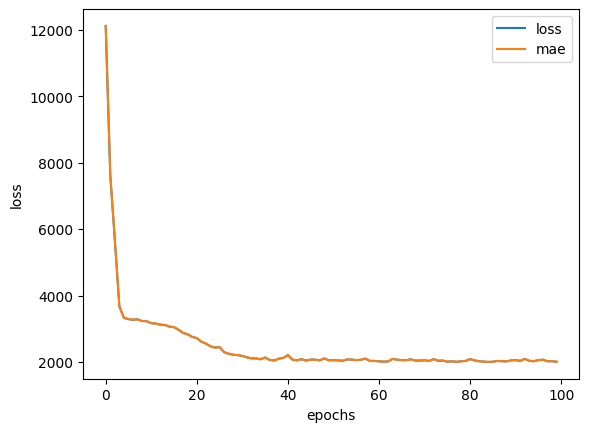

In [25]:
pd.DataFrame(history.history).plot()
plt.ylabel('loss')
plt.xlabel('epochs')

9/9 [==============================] - 0s 2ms/step


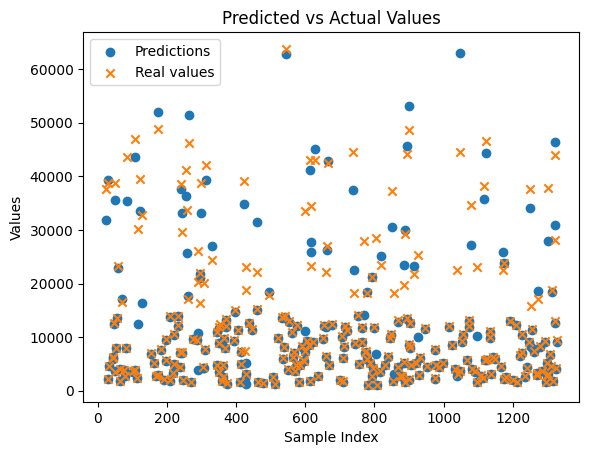

In [26]:
y_predict = model.predict(X_test_normal)
df = pd.DataFrame({'Predicted': y_predict.squeeze(), 'Actual': y_test})

plt.scatter(df.index, df['Predicted'], marker='o', label='Predictions')
plt.scatter(df.index, df['Actual'], marker='x', label='Real values')
plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.title('Predicted vs Actual Values')
plt.show()

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               1200      
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 10)                1010      
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 12321 (48.13 KB)
Trainable params: 12321 (48.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
